In [13]:
import os
import re
import numpy as np
import pandas as pd
import json
import yaml
from sklearn.model_selection import train_test_split
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shutil
from operator import is_not
from functools import partial
import PIL.Image
HOME = os.getcwd()
import ultralytics 
from ultralytics import YOLO
from IPython.display import display, Image
from IPython import display
display.clear_output()
!yolo checks

Ultralytics YOLOv8.2.19 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
Setup complete ✅ (72 CPUs, 250.5 GB RAM, 1867.3/1876.2 GB disk)

OS                  Linux-5.15.0-107-generic-x86_64-with-glibc2.29
Environment         Linux
Python              3.8.10
Install             pip
RAM                 250.54 GB
CPU                 Intel Xeon Gold 5220 2.20GHz
CUDA                12.1

matplotlib          ✅ 3.7.5>=3.3.0
opencv-python       ✅ 4.8.0.74>=4.6.0
pillow              ✅ 10.2.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.31.0>=2.23.0
scipy               ✅ 1.10.1>=1.4.1
torch               ✅ 2.2.1>=1.8.0
torchvision         ✅ 0.17.1>=0.9.0
tqdm                ✅ 4.66.2>=4.64.0
psutil              ✅ 5.9.8
py-cpuinfo          ✅ 9.0.0
thop                ✅ 0.1.1-2209072238>=0.1.1
pandas              ✅ 2.0.3>=1.1.4
seaborn             ✅ 0.13.2>=0.11.0


In [2]:
#!pip install -U ultralytics
#!pip install -U opencv-python
#HOME

In [3]:
def get_image_mask_pairs(data_dir):
    """
    retrieve image and mask from a given directory
    """
    image_paths = []
    mask_paths = []

    for root, _, files in os.walk(data_dir):
        if 'train' in root:
            if 'imgs' in root:
                for file in files:
                    if file.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp','.tif', '.tiff')):
                        image_paths.append(os.path.join(root, file))
            elif 'masks' in root:
                for file in files:
                    if file.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp','.tif', '.tiff')):
                        mask_paths.append(os.path.join(root, file))

    return image_paths, mask_paths


In [7]:
#tp =cv2.imread("img_00309.tiff")

In [4]:
def get_image_mask_pairs(data_dir):
    """
    retrieve image and mask from a given directory
    """
    image_paths = []
    mask_paths = []
    
    for root, _, files in os.walk(data_dir):
        if 'images' in root:
            for file in files:
                if file.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp','.tif', '.tiff')):
                    image_paths.append(os.path.join(root, file))
                    _, ext= os.path.splitext(file)
                    mask_paths.append(os.path.join(root.replace('images', 'masks'), file.replace("img", "masks").replace(ext, ".tiff")))
                      
    return image_paths, mask_paths

def mask_to_polygons(mask):

    """
        Draw contours arround the mask 
    """

    # Find the contour of an object precisely the coordonnates of the boundary shape
    # Use RETR_TREE retrievial hierachy mode 
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if len(contour) > 2:
            poly = contour.reshape(-1).tolist()
            if len(poly) > 4:  # Ensure valid polygon
                polygons.append(poly)
    return polygons

def process_data(image_paths, mask_paths, output_dir):
    annotations = []
    images = []
    image_id = 0
    ann_id = 0
    
    for img_path, mask_path in zip(image_paths, mask_paths):
        image_id += 1
        img = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR)
        if img is None:
            print(f"Could not read image file: {img_path}")
            continue
        #print(image_id, type(img))
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED) #return the loaded image as is (with alpha channel, otherwise it gets cropped).
        
        # Copy image to output directory
        shutil.copy(img_path, os.path.join(output_dir, os.path.basename(img_path)))
        
        images.append({
            "id": image_id,
            "file_name": os.path.basename(img_path),
            "height": img.shape[0],
            "width": img.shape[1]
        })
        
        unique_values = np.unique(mask)
        for value in unique_values:
            if value == 0:  # Ignore background
                continue
            
            object_mask = (mask == value).astype(np.uint8) * 255
            polygons = mask_to_polygons(object_mask)
            
            for poly in polygons:
                ann_id += 1
                annotations.append({
                    "id": ann_id,
                    "image_id": image_id,
                    "category_id": 1,  # Only one category: Cellular
                    "segmentation": [poly],
                    "area": cv2.contourArea(np.array(poly).reshape(-1, 2)),
                    "bbox": list(cv2.boundingRect(np.array(poly).reshape(-1, 2))),
                    "iscrowd": 0
                })
    
        coco_output = {
            "images": images,
            "annotations": annotations,
            "categories": [{"id": 1, "name": "Cellular"}]
        }
        
        with open(os.path.join(output_dir, 'coco_annotations.json'), 'w') as f:
            json.dump(coco_output, f)


In [5]:
data_dir = HOME

In [6]:

data_dir = HOME
output_dir = 'COCO_output'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')

# Create output directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

image_paths, mask_paths = get_image_mask_pairs(data_dir)

# Split data into train and val
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Process train and val data
process_data(train_img_paths, train_mask_paths, train_dir)
process_data(val_img_paths, val_mask_paths, val_dir)

Could not read image file: /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/EvaluationV1.2/train/images/img_00701.tiff
Could not read image file: /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/EvaluationV1.2/train/images/img_00507.tif
Could not read image file: /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/EvaluationV1.2/train/images/img_00702.tiff
Could not read image file: /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/EvaluationV1.2/train/images/img_00718.tiff
Could not read image file: /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/EvaluationV1.2/train/images/img_00306.tiff
Could not read image file: /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/EvaluationV1.2/train/images/img_00705.tiff
Could not read image file: /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/EvaluationV1.2/train/images/img_00314.tiff
Could not read image file: /home/kamenan/Document

In [7]:
def display_images_with_coco_annotations(image_paths:str, annotations:str, display_type='both'):
    """
    Lay out the images with the COCO annotations
    Params:
    ------
         Image_paths: the paths where the converted COCO.json has been stored
         annotations: path to anotations files
         display_both: Lay out annotated images along side the original image

    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    for ax, img_path in zip(axs.ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Get image filename to match with annotations
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']
        
        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]
        
        # Generate random colors for each annotation
        colors = [tuple(np.random.rand(3)) for _ in img_annotations]

        for ann, color in zip(img_annotations, colors):
            # Display bounding box
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                                         linewidth=1, edgecolor=color, 
                                         facecolor='none')
                #ax.add_patch(rect)
            
            # Display segmentation polygon
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    polygon = patches.Polygon(poly, closed=True, edgecolor=color, 
                                              fill=False)
                    ax.add_patch(polygon)

    plt.tight_layout()
    plt.show()



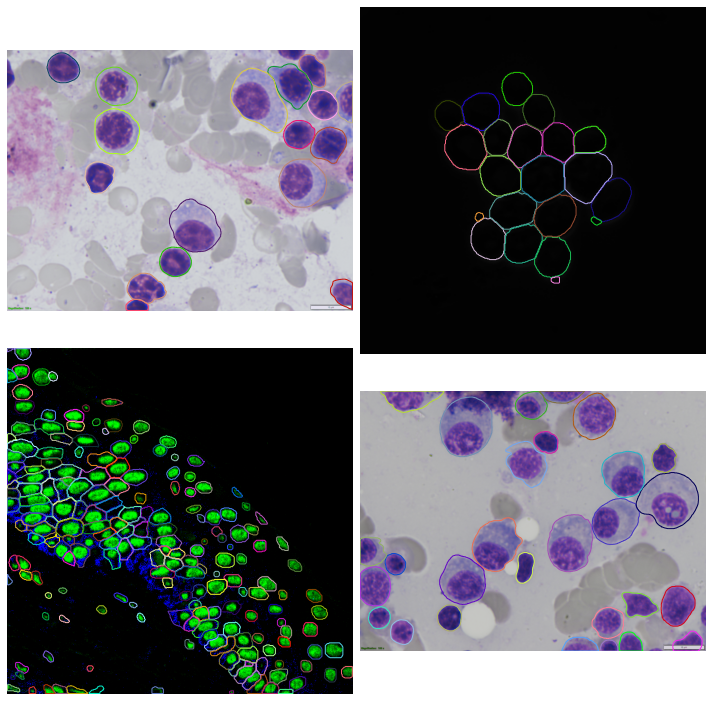

In [8]:
# Load COCO annotations
with open('COCO_output/train/coco_annotations.json', 'r') as f:
    annotations = json.load(f)

# Get all image files
image_dir = "COCO_output/train/"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]

#Get some image at random
random_image_files = random.sample(all_image_files, 4)

# Choose between 'bbox', 'seg', or 'both'
display_type = 'seg'
display_images_with_coco_annotations(random_image_files, annotations, display_type)

In [12]:
"""
This code transforms a dataset of images and annotations into a format suitable 
for training a YOLO (You Only Look Once) object detection model, and it also 
creates a YAML configuration file required for training the model.

It reads coco style json annotations supplied as a single json file and also 
images as input. 

Here are the key steps in the code:

1. Convert Images to YOLO Format: The convert_to_yolo function takes paths for 
input images and annotations (in JSON format), and directories to store the 
output images and labels. It then performs the following operations:

- Reads the input JSON file containing annotations.
- Copies all PNG images from the input directory to the output directory.
- Normalizes the polygon segmentation data related to each image and writes 
them to text files, mapping them to the appropriate category 
(e.g., Alpha, Cells, Mito, Vessels).
- The resulting text files contain information about the object category and the normalized coordinates of the polygons that describe the objects.

2. Create YAML Configuration File: The create_yaml function takes paths to the input JSON file containing categories, training, validation, and optional test paths. It then:

- Extracts the category names and the number of classes.
- Constructs a dictionary containing information about class names, the number 
of classes, and paths to the training, validation, and test datasets.
- Writes this dictionary to a YAML file, which can be used as a configuration 
file for training a model (e.g., a YOLO model).
    


The text annotation file consists of lines representing individual object 
annotations, with each line containing the class ID followed by the normalized 
coordinates of the polygon describing the object.

Example structure of the YOLO annotation file:

<class_id> <normalized_polygon_coordinate_1> <normalized_polygon_coordinate_2> ... <normalized_polygon_coordinate_n>
0 0.123456 0.234567 0.345678 0.456789 ...

"""



# Function to convert images to YOLO format
def convert_to_yolo(input_images_path, input_json_path, output_images_path, output_labels_path):
    # Open JSON file containing image annotations
    f = open(input_json_path)
    data = json.load(f)
    f.close()

    # Create directories for output images and labels
    os.makedirs(output_images_path, exist_ok=True)
    os.makedirs(output_labels_path, exist_ok=True)

    # List to store filenames
    file_names = []
    for filename in os.listdir(input_images_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp','.tif', '.tiff')):
            source = os.path.join(input_images_path, filename)
            destination = os.path.join(output_images_path, filename)
            shutil.copy(source, destination)
            file_names.append(filename)

    # Function to get image annotations
    def get_img_ann(image_id):
        return [ann for ann in data['annotations'] if ann['image_id'] == image_id]

    # Function to get image data
    def get_img(filename):
        return next((img for img in data['images'] if img['file_name'] == filename), None)

    # Iterate through filenames and process each image
    for filename in file_names:
        img = get_img(filename)
        img_id = img['id']
        img_w = img['width']
        img_h = img['height']
        img_ann = get_img_ann(img_id)

        # Write normalized polygon data to a text file
        if img_ann:
            with open(os.path.join(output_labels_path, f"{os.path.splitext(filename)[0]}.txt"), "a") as file_object:
                for ann in img_ann:
                    current_category = ann['category_id'] - 1
                    polygon = ann['segmentation'][0]
                    normalized_polygon = [format(coord / img_w if i % 2 == 0 else coord / img_h, '.6f') for i, coord in enumerate(polygon)]
                    file_object.write(f"{current_category} " + " ".join(normalized_polygon) + "\n")

# Function to create a YAML file for the dataset
def create_yaml(input_json_path, output_yaml_path, train_path, val_path, test_path=None):
    with open(input_json_path) as f:
        data = json.load(f)
    
    # Extract the category names
    names = [category['name'] for category in data['categories']]
    
    # Number of classes
    nc = len(names)

    # Create a dictionary with the required content
    yaml_data = {
        'names': names,
        'nc': nc,
        'test': test_path if test_path else '',
        'train': train_path,
        'val': val_path
    }

    # Write the dictionary to a YAML file
    with open(output_yaml_path, 'w') as file:
        yaml.dump(yaml_data, file, default_flow_style=False)




### Test

In [10]:
base_input_path = "COCO_output/"
base_output_path = "yolo_dataset/"

In [13]:
# Processing validation dataset (if needed)
convert_to_yolo(
    input_images_path=os.path.join(base_input_path, "val"),
    input_json_path=os.path.join(base_input_path, "val/coco_annotations.json"),
    output_images_path=os.path.join(base_output_path, "valid/images"),
    output_labels_path=os.path.join(base_output_path, "valid/labels")
)

In [14]:
# Processing training dataset 
convert_to_yolo(
    input_images_path=os.path.join(base_input_path, "train"),
    input_json_path=os.path.join(base_input_path, "train/coco_annotations.json"),
    output_images_path=os.path.join(base_output_path, "train/images"),
    output_labels_path=os.path.join(base_output_path, "train/labels")
)

In [15]:
# Creating the YAML configuration file
create_yaml(
    input_json_path=os.path.join(base_input_path, "train/coco_annotations.json"),
    output_yaml_path=os.path.join(base_output_path, "data.yaml"),
    train_path="train/images",
    val_path="valid/images",
    test_path='../test/images'  # or None if not applicable
)

### Visualize YOLO labels

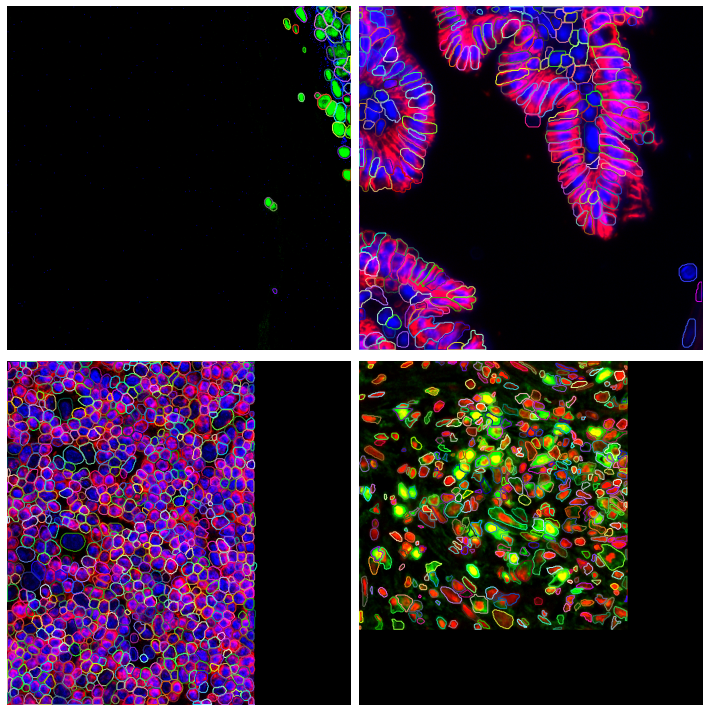

In [16]:
def display_images_with_annotations(image_paths, annotation_paths):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    for ax, img_path, ann_path in zip(axs.ravel(), image_paths, annotation_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_h, img_w, _ = image.shape
        
        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Open the annotation file and process each line
        with open(ann_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                category_id = int(parts[0])
                color = tuple(np.random.rand(3))  # Generate a random RGB color
                polygon = [float(coord) for coord in parts[1:]]
                polygon = [coord * img_w if i % 2 == 0 else coord * img_h for i, coord in enumerate(polygon)]
                polygon = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
                patch = patches.Polygon(polygon, closed=True, edgecolor=color, fill=False)
                ax.add_patch(patch)

    plt.tight_layout()
    plt.show()

# Get all image files
image_dir = "yolo_dataset/train/images/"
annotation_dir = "yolo_dataset/train/labels/"
all_image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
random_image_files = random.sample(all_image_files, 4)

# Get corresponding annotation files
image_paths = [os.path.join(image_dir, f) for f in random_image_files]
annotation_paths = [os.path.join(annotation_dir, f.replace(".png", ".txt")) for f in random_image_files]

display_images_with_annotations(image_paths, annotation_paths)

### Training a model

In [20]:
HOME

'/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/EvaluationV1.2'

In [ ]:
/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/EvaluationV1.2/best.pt

In [21]:
model = YOLO("yolov8l-seg.yaml") # build a new model from yaml
model = YOLO("best.pt") # yolov8l-seg pre-trained with cellpose data

In [5]:
!pip install torchinfo

In [12]:
#import torchinfo

print(model)

YOLO(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(320, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, trac

In [23]:
with open('yolo_dataset/data.yaml', 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [25]:
cellpose_projct = "yolo_dataset/results"
name = "125_epochs_pretrained_by_cyto1_data"

### Hyperparamleter tuning

In [9]:
# Hyperparameters space
space = {  # key: (min, max, gain(optional))
            #"optimizer": ('SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp'),
            "lr0": (1e-5, 1e-1),  # initial learning rate (i.e. SGD=1E-2, Adam=1E-3)
            "lrf": (0.0001, 0.1),  # final OneCycleLR learning rate (lr0 * lrf)
            "momentum": (0.7, 0.98, 0.3),  # SGD momentum/Adam beta1
            "weight_decay": (0.0, 0.001),  # optimizer weight decay 5e-4
            "warmup_epochs": (0.0, 5.0),  # warmup epochs (fractions ok)
            "warmup_momentum": (0.0, 0.95),  # warmup initial momentum
            "box": (1.0, 20.0),  # box loss gain
            "cls": (0.2, 4.0),  # cls loss gain (scale with pixels
            "label_smoothing": (0.0, 1.0),
            "dfl": (0.4, 6.0),  # dfl loss gain
            "hsv_h": (0.0, 0.1),  # image HSV-Hue augmentation (fraction)
            "hsv_s": (0.0, 0.9),  # image HSV-Saturation augmentation (fraction)
            "hsv_v": (0.0, 0.9),  # image HSV-Value augmentation (fraction)
            "degrees": (-180.0, 180.0),  # image rotation (+/- deg)
            "translate": (0.0, 1.0),  # image translation (+/- fraction)
            "scale": (0.0, 0.95),  # image scale (+/- gain)
            "shear": (-180.0, 180.0),  # image shear (+/- deg)
            "perspective": (0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
            "flipud": (0.0, 1.0),  # image flip up-down (probability)
            "fliplr": (0.0, 1.0),  # image flip left-right (probability)
            "bgr": (0.0, 1.0),  # image channel bgr (probability)
            "mosaic": (0.0, 1.0),  # image mixup (probability)
            "mixup": (0.0, 1.0),  # image mixup (probability)
            "erasing": (0.0, 0.9),
            "crop_fraction": (0., 1.0),
            "copy_paste": (0.0, 1.0),  # segment copy-paste (probability)
        }

In [2]:
#model.tune(data='yolo_dataset/data.yaml',
#           space=space,
#           epochs=100,
#           iterations=300,
#           optimizer= "AdamW",
#           plots=False,
#           save=False,
#           val=False
#           )

In [ ]:
lr0: 0.00639
lrf: 0.01359
momentum: 0.82463
weight_decay: 0.00056
warmup_epochs: 5.0
warmup_momentum: 0.95
box: 7.32878
cls: 0.54104
label_smoothing: 0.0
dfl: 1.80966
hsv_h: 0.01757
hsv_s: 0.53852
hsv_v: 0.50795
degrees: 0.0
translate: 0.0851
scale: 0.27919
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.53478
bgr: 0.0
mosaic: 0.65076
mixup: 0.0
erasing: 0.26514
crop_fraction: 0.91867
copy_paste: 0.0

In [ ]:
"""
Tune parameters on cellpose data
                      patience=0, #I am setting patience=0 to disable early stopping.
                      batch=16,
                      device=0,
                      lr0=0.00274,
                      lrf=0.00871,
                      momentum=0.90582,
                      weight_decay=0.00047,
                      warmup_epochs=2.52061,
                      warmup_momentum=0.7389,
                      box=4.03359,
                      cls=0.26603,
                      dfl=1.29304,
                      hsv_h=0.0322,
                      hsv_s=0.49721,
                      hsv_v=0.43837,
                      degrees=0.0,
                      translate=0.10623,
                      scale=0.70133,
                      shear=0.0,
                      perspective=0.0,
                      flipud=0.0,
                      fliplr=0.14719,
                      bgr=0.0,
                      mosaic=0.87496,
                      mixup=0.0,
                      copy_paste=0.0
"""                      
                      

In [19]:
#!pip install lancedb

In [26]:
# Train the model with tune parameters on MEDIAR data
results = model.train(data='yolo_dataset/data.yaml',
                    project=cellpose_projct,
                    name=name,
                    epochs=125
                    )
     
     

New https://pypi.org/project/ultralytics/8.2.35 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.19 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
engine/trainer: task=segment, mode=train, model=best.pt, data=yolo_dataset/data.yaml, epochs=125, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolo_dataset/results, name=125_epochs_pretrained_by_cyto1_data, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, reti

train: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/EvaluationV1.2/yolo_dataset/train/labels.cache... 764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 764/764 [00:00<?, ?it/s]
val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/EvaluationV1.2/yolo_dataset/valid/labels.cache... 195 images, 0 backgrounds, 0 corrupt: 100%|██████████| 195/195 [00:00<?, ?it/s]


Plotting labels to yolo_dataset/results/125_epochs_pretrained_by_cyto1_data/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_dataset/results/125_epochs_pretrained_by_cyto1_data
Starting training for 125 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/125      30.6G      2.017      3.124      1.157      1.298       1670        640: 100%|██████████| 48/48 [01:10<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        195      32118        0.7       0.47      0.535      0.287      0.695      0.462      0.529      0.261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/125      24.3G      1.744      2.554     0.8747      1.125       2756        640: 100%|██████████| 48/48 [00:47<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]

                   all        195      32118      0.761      0.452      0.541        0.3      0.761       0.45      0.538      0.276



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/125      33.4G      1.636      2.385     0.8344      1.096       1465        640: 100%|██████████| 48/48 [00:46<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]

                   all        195      32118      0.798      0.514       0.58      0.328      0.791      0.501      0.568      0.288



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/125      31.4G      1.661      2.391     0.8258      1.102       1823        640: 100%|██████████| 48/48 [00:47<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

                   all        195      32118      0.773      0.504      0.568       0.32      0.763      0.493      0.554      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/125        30G      1.624       2.34     0.8044      1.093       4724        640: 100%|██████████| 48/48 [00:47<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]

                   all        195      32118      0.814      0.553      0.617       0.36        0.8       0.54        0.6      0.317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/125      29.6G      1.594      2.271     0.7772      1.084       1890        640: 100%|██████████| 48/48 [00:47<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]

                   all        195      32118      0.814      0.521      0.613      0.348      0.808      0.515      0.605      0.305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/125      30.8G      1.603      2.252     0.7831      1.081       2688        640: 100%|██████████| 48/48 [00:47<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]

                   all        195      32118      0.829      0.542      0.622      0.356      0.822      0.535      0.614      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/125        32G      1.563      2.202      0.774      1.078       2741        640: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]

                   all        195      32118      0.786      0.526      0.594      0.338      0.773      0.502      0.569      0.271



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/125      25.8G      1.546      2.175     0.7621      1.064       2303        640: 100%|██████████| 48/48 [00:47<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

                   all        195      32118      0.836       0.54      0.617      0.356      0.833      0.527      0.605      0.313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/125      30.6G      1.514      2.133      0.741      1.056       1842        640: 100%|██████████| 48/48 [00:47<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

                   all        195      32118      0.833      0.563      0.628      0.371      0.825      0.551      0.614       0.31



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/125      31.7G      1.508        2.1     0.7376       1.05       3803        640: 100%|██████████| 48/48 [00:47<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]

                   all        195      32118      0.846      0.559       0.64       0.37       0.84      0.548       0.63      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/125      32.9G      1.537       2.15     0.7471      1.049       2966        640: 100%|██████████| 48/48 [00:47<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        195      32118      0.842      0.562      0.632      0.377      0.839      0.551      0.619      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/125      29.6G      1.529       2.18     0.7463      1.048       1922        640: 100%|██████████| 48/48 [00:47<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.42s/it]

                   all        195      32118      0.844       0.57      0.642       0.39      0.844      0.558      0.631      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/125      33.1G      1.517      2.116     0.7335      1.047       2482        640: 100%|██████████| 48/48 [00:48<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

                   all        195      32118      0.848      0.572      0.654      0.401       0.84      0.563      0.644      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/125      29.5G      1.489      2.085     0.7136      1.039       4045        640: 100%|██████████| 48/48 [00:48<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]

                   all        195      32118       0.86       0.56      0.652      0.397      0.857      0.553      0.646      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/125      37.6G       1.48      2.084     0.7085      1.036       2736        640: 100%|██████████| 48/48 [00:47<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]

                   all        195      32118      0.839      0.541      0.621      0.364       0.83      0.533      0.611      0.313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/125      33.9G      1.488      2.078     0.7124      1.031       3243        640: 100%|██████████| 48/48 [00:48<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.33s/it]

                   all        195      32118      0.861      0.585      0.661      0.401      0.859      0.574      0.651      0.341



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/125      31.4G      1.469      2.053      0.711      1.038       3595        640: 100%|██████████| 48/48 [00:48<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]

                   all        195      32118      0.858       0.58      0.645      0.392      0.857      0.575      0.641      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/125      34.5G       1.47      2.006     0.6997      1.032       3175        640: 100%|██████████| 48/48 [00:48<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        195      32118      0.861      0.586      0.652      0.402      0.859      0.583      0.647       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/125      35.7G      1.462      2.039     0.6925      1.028       1706        640: 100%|██████████| 48/48 [00:48<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        195      32118      0.857      0.583      0.662      0.407      0.851      0.572      0.652      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/125      27.5G      1.468      2.075     0.7121      1.039       1411        640: 100%|██████████| 48/48 [00:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

                   all        195      32118      0.857      0.578       0.66      0.409      0.851      0.564      0.647      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/125      33.4G      1.456       2.05     0.6918       1.03       2769        640: 100%|██████████| 48/48 [00:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


                   all        195      32118      0.862      0.585      0.662      0.408      0.858      0.579      0.654      0.363

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/125      22.3G      1.454      2.023     0.6843       1.02       3047        640: 100%|██████████| 48/48 [00:47<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


                   all        195      32118      0.865      0.584      0.668      0.413       0.86      0.577      0.661      0.351

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/125      21.5G      1.451       2.03     0.6916      1.029       4173        640: 100%|██████████| 48/48 [00:48<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]

                   all        195      32118      0.865      0.584      0.688      0.434       0.86      0.573      0.678      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/125      35.4G      1.415      1.977      0.675       1.02       3206        640: 100%|██████████| 48/48 [00:46<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        195      32118      0.859      0.584      0.666      0.411      0.852      0.574      0.658      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/125      34.6G      1.462      2.004     0.6872      1.032       3171        640: 100%|██████████| 48/48 [00:47<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]

                   all        195      32118      0.844      0.563      0.636      0.385      0.829      0.544      0.614      0.305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/125      23.6G      1.438      1.984     0.6812      1.021       2853        640: 100%|██████████| 48/48 [00:47<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

                   all        195      32118      0.854      0.576      0.655      0.398      0.839      0.563      0.636      0.319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/125      29.5G      1.429      1.999     0.6768      1.021       1697        640: 100%|██████████| 48/48 [00:46<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        195      32118      0.848      0.577      0.658      0.411      0.855      0.568      0.651      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/125      31.6G      1.417      2.002     0.6766      1.024       3521        640: 100%|██████████| 48/48 [00:46<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        195      32118      0.851       0.58      0.649      0.398      0.844      0.569      0.637      0.341



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/125      37.3G      1.404       1.98     0.6667      1.023       3269        640: 100%|██████████| 48/48 [00:46<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]

                   all        195      32118      0.853      0.584      0.657      0.408      0.848      0.573      0.646      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/125      31.3G      1.396      1.987     0.6721      1.016        766        640: 100%|██████████| 48/48 [00:47<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]

                   all        195      32118      0.864      0.582      0.648      0.407      0.853      0.571      0.635      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/125        39G      1.392      1.954     0.6634      1.019       2779        640: 100%|██████████| 48/48 [00:47<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]

                   all        195      32118      0.851      0.563       0.64      0.395      0.839      0.549      0.625      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/125      31.8G      1.408      1.964     0.6799      1.022       1841        640: 100%|██████████| 48/48 [00:46<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]

                   all        195      32118      0.851      0.568      0.639      0.392      0.843      0.554      0.625      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/125        32G       1.39      1.958     0.6768      1.008       4650        640: 100%|██████████| 48/48 [00:47<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

                   all        195      32118       0.87      0.587      0.672      0.416      0.867      0.577      0.664      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/125        34G      1.395      1.937     0.6576      1.012       2118        640: 100%|██████████| 48/48 [00:46<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

                   all        195      32118      0.863      0.584      0.672      0.417      0.855      0.575      0.662      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/125      28.1G      1.362      1.901     0.6515      1.005       2251        640: 100%|██████████| 48/48 [00:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]

                   all        195      32118      0.873      0.595      0.683      0.438      0.866      0.586      0.675      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/125      36.5G       1.37      1.897     0.6434      1.008       1450        640: 100%|██████████| 48/48 [00:47<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]

                   all        195      32118      0.875      0.587      0.678       0.43      0.869      0.575      0.666       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/125      31.5G      1.387      1.907      0.645      1.016       2626        640: 100%|██████████| 48/48 [00:46<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]

                   all        195      32118      0.864      0.587       0.67       0.42      0.861      0.577      0.662      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/125      28.4G      1.409      1.968      0.662       1.02       2628        640: 100%|██████████| 48/48 [00:46<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]

                   all        195      32118      0.857      0.582      0.653      0.404       0.86      0.576       0.65      0.361



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/125      33.8G      1.383      1.929     0.6511      1.003       2801        640: 100%|██████████| 48/48 [00:47<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]

                   all        195      32118      0.863      0.592      0.673       0.43      0.854       0.58       0.66      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/125      37.2G      1.352      1.882     0.6342     0.9923       4000        640: 100%|██████████| 48/48 [00:47<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]

                   all        195      32118      0.857      0.586      0.679      0.432      0.851      0.572      0.665      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/125      34.9G      1.334      1.883      0.631      1.004       3704        640: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        195      32118      0.868      0.586      0.664      0.417      0.864      0.579      0.657      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/125      25.9G      1.358      1.909     0.6437      1.003       2636        640: 100%|██████████| 48/48 [00:47<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]

                   all        195      32118      0.867      0.592      0.663      0.419       0.85       0.58      0.648      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/125      31.6G      1.363      1.885     0.6392      1.003       2417        640: 100%|██████████| 48/48 [00:47<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]

                   all        195      32118      0.871      0.586       0.67      0.422      0.862      0.579       0.66      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/125      42.4G      1.373      1.912      0.643      0.999       3886        640: 100%|██████████| 48/48 [00:46<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

                   all        195      32118      0.869      0.592      0.677      0.423      0.858       0.58      0.663       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/125      27.7G      1.381       1.92     0.6459       1.01       3512        640: 100%|██████████| 48/48 [00:46<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]

                   all        195      32118      0.876       0.59      0.681      0.432      0.864      0.577      0.667      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/125      32.3G      1.346      1.873     0.6269      1.002       2556        640: 100%|██████████| 48/48 [00:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        195      32118      0.869      0.598      0.677      0.434       0.86      0.587      0.662      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/125      31.6G      1.378      1.904     0.6429      1.005       2344        640: 100%|██████████| 48/48 [00:46<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

                   all        195      32118      0.863      0.586      0.663       0.42      0.856      0.576      0.651      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/125      26.6G      1.349      1.878     0.6292      0.996       2176        640: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        195      32118      0.872      0.596       0.68      0.438      0.867      0.587      0.671      0.376



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/125      32.4G      1.357      1.881     0.6398     0.9981       2991        640: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]

                   all        195      32118      0.854      0.579      0.657      0.401      0.836      0.561      0.636      0.317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/125      29.1G       1.33      1.845     0.6256     0.9939       1593        640: 100%|██████████| 48/48 [00:43<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

                   all        195      32118      0.877      0.592      0.676      0.434      0.868      0.581      0.665      0.367



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/125      31.1G      1.322      1.821     0.6183     0.9876       1908        640: 100%|██████████| 48/48 [00:43<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.43s/it]

                   all        195      32118      0.877      0.597      0.691      0.439      0.868      0.584      0.678      0.371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/125      29.2G      1.373      1.917      0.633     0.9989       2709        640: 100%|██████████| 48/48 [00:48<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]

                   all        195      32118      0.873      0.586      0.682      0.436      0.861      0.572      0.666      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/125      30.3G      1.353      1.865     0.6226     0.9905       2282        640: 100%|██████████| 48/48 [00:46<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

                   all        195      32118      0.877        0.6      0.703      0.455      0.869      0.591      0.694      0.394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/125      24.3G      1.339      1.852     0.6216     0.9997       3507        640: 100%|██████████| 48/48 [00:45<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]

                   all        195      32118      0.868      0.598      0.685      0.442      0.859      0.581      0.667       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/125      28.8G      1.348      1.871     0.6191     0.9941       1991        640: 100%|██████████| 48/48 [00:48<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        195      32118      0.879      0.593      0.674      0.432       0.87      0.584      0.663      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/125      32.9G      1.334      1.834     0.6192     0.9869       2406        640: 100%|██████████| 48/48 [00:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.33s/it]

                   all        195      32118      0.874      0.597      0.674      0.429      0.867      0.585      0.662      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/125      27.5G      1.362      1.856     0.6225     0.9969       2684        640: 100%|██████████| 48/48 [00:47<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


                   all        195      32118      0.885        0.6      0.682      0.437      0.876      0.592      0.673       0.37

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/125      28.5G      1.303      1.781     0.6045     0.9835       2899        640: 100%|██████████| 48/48 [00:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]

                   all        195      32118      0.873      0.599      0.711       0.46      0.872      0.589      0.701      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/125      23.3G      1.341      1.841     0.6213     0.9997       1947        640: 100%|██████████| 48/48 [00:46<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]

                   all        195      32118      0.871      0.592      0.692      0.455      0.867      0.587      0.687      0.397



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/125      25.9G       1.32      1.834     0.6124     0.9956       4750        640: 100%|██████████| 48/48 [00:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

                   all        195      32118      0.871      0.596      0.681      0.432      0.863       0.58      0.662      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/125        28G      1.336      1.848     0.6186     0.9903       2231        640: 100%|██████████| 48/48 [00:48<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

                   all        195      32118      0.872      0.599      0.699      0.456       0.87      0.591      0.691      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/125        29G      1.343      1.854     0.6214     0.9919       2740        640: 100%|██████████| 48/48 [00:47<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]

                   all        195      32118      0.874      0.584       0.69      0.441      0.864      0.565      0.671      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/125      30.3G      1.306      1.821     0.6098     0.9852       3511        640: 100%|██████████| 48/48 [00:46<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.33s/it]

                   all        195      32118      0.876      0.599      0.677      0.433      0.873      0.589      0.668      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/125        35G      1.304      1.804      0.605     0.9837       2822        640: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]

                   all        195      32118      0.876      0.593      0.666       0.42      0.872      0.586      0.658      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/125      27.8G      1.301      1.806     0.5997     0.9839       3852        640: 100%|██████████| 48/48 [00:46<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


                   all        195      32118      0.871      0.596      0.678      0.442       0.86      0.582      0.663       0.36

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/125      33.9G      1.289      1.788     0.5952     0.9867       2179        640: 100%|██████████| 48/48 [00:46<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        195      32118      0.879      0.601      0.705      0.461      0.867      0.587      0.689      0.379



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/125      35.6G       1.31      1.809     0.6065     0.9818       3252        640: 100%|██████████| 48/48 [00:46<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

                   all        195      32118      0.875      0.594      0.686      0.433      0.865      0.584      0.675      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/125      33.2G      1.292       1.77     0.5915     0.9753       2105        640: 100%|██████████| 48/48 [00:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        195      32118      0.879        0.6      0.686      0.441      0.872       0.59      0.676       0.38



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/125      21.5G      1.346       1.93     0.6266      1.019       2118        640:  15%|█▍        | 7/48 [00:06<00:36,  1.11it/s]

In [3]:
#model = YOLO('yolo_dataset/results/100v9e_epochs/weights/best.pt')
#metrics= model.val(data='yolo_dataset/data.yaml', device=0).results_dict

In [ ]:
import os
import numpy as np
import torch
import clip
from PIL import Image
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

# Configuration du dispositif
device = "cuda" if torch.cuda.is_available() else "cpu"

# Charger le modèle CLIP et le preprocess
model, preprocess = clip.load("ViT-B/32", device=device)

# Fonction pour obtenir les embeddings d'une image
def get_image_embedding(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image)
    return embedding.cpu().numpy()

# Charger les embeddings de toutes les images d'un répertoire
def get_embeddings_from_directory(directory):
    embeddings = []
    image_paths = []
    for filename in os.listdir(directory):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(directory, filename)
            embedding = get_image_embedding(image_path)
            embeddings.append(embedding)
            image_paths.append(image_path)
    return np.concatenate(embeddings), image_paths

# Répertoire contenant les images
image_directory = "path/to/your/images"

# Obtenir les embeddings des images
embeddings, image_paths = get_embeddings_from_directory(image_directory)

# Réduire la dimensionnalité avec UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
embeddings_reduced = umap_reducer.fit_transform(embeddings)

# Fonction pour afficher les clusters
def plot_clusters(embeddings, labels, image_paths):
    plt.figure(figsize=(10, 8))
    unique_labels = set(labels)
    for label in unique_labels:
        indices = [i for i, lbl in enumerate(labels) if lbl == label]
        plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=f'Cluster {label}')
    plt.legend()
    plt.title("Clusters")
    plt.show()

# Choisir l'algorithme de clustering
clustering_algorithm = "dbscan"  # ou "tsne"

if clustering_algorithm == "dbscan":
    # Clustering avec DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
    labels = dbscan.fit_predict(embeddings_reduced)
elif clustering_algorithm == "tsne":
    # Réduire la dimensionnalité avec t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    embeddings_reduced_tsne = tsne.fit_transform(embeddings_reduced)
    # Clustering avec DBSCAN sur les embeddings t-SNE
    dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
    labels = dbscan.fit_predict(embeddings_reduced_tsne)
    embeddings_reduced = embeddings_reduced_tsne

# Afficher les clusters
plot_clusters(embeddings_reduced, labels, image_paths)

# Fonction pour obtenir le cluster d'une image
def get_image_cluster(image_path):
    embedding = get_image_embedding(image_path)
    embedding_reduced = umap_reducer.transform(embedding)
    if clustering_algorithm == "tsne":
        embedding_reduced = tsne.fit_transform(embedding_reduced)
    label = dbscan.fit_predict(embedding_reduced)
    return label[0]

# Exemples d'utilisation
image_path = "path/to/your/image.png"
cluster_label = get_image_cluster(image_path)
print(f"L'image {image_path} appartient au cluster {cluster_label}")


In [11]:
def evaluation(model, data_dir, ious):

    #ious = np.linspace(.5,1,50)
    precision = []
    recall = []
    jac_idx = []
    for io in ious:
        tp_eval = YOLO(model)
        metrics = tp_eval.val(data= data_dir,
                              iou=io,
                              device=0
                              )
        precision.append(metrics.results_dict["metrics/precision(B)"])
        recall.append(metrics.results_dict["metrics/recall(B)"])
        conf_mtrx = metrics.confusion_matrix
        j_idx = conf_mtrx.matrix[0][0]/conf_mtrx.matrix.sum()
        jac_idx.append(j_idx)
    return jac_idx, precision, recall

In [1]:
#jac_idx, precision, recall = evaluation(model="yolo_dataset/results/100v9e_epochs/weights/best.pt", data_dir="yolo_dataset/data.yaml", ious=np.linspace(.5,1,50))


In [14]:
# Différents seuils de iou
ious = np.linspace(.5,1,50)


(0.0, 1.0)

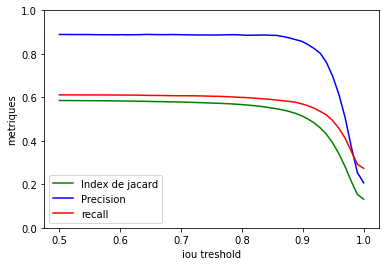

In [15]:
# V9 with best v8 tune parameters

%matplotlib inline

# Définir la figure
fig, ax = plt.subplots()

# Index de Jacard, precision, recall
ax.plot(ious, jac_idx, color='green', label="Index de jacard")
ax.plot(ious, precision, color='blue', label="Precision")
ax.plot(ious, recall, color="red", label="recall")
ax.legend(loc="best")
ax.set_xlabel('iou treshold')
ax.set_ylabel("metriques")
ax.set_ylim([0,1])

(0.0, 1.0)

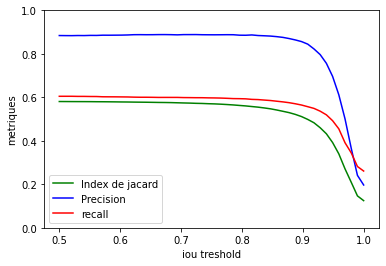

In [17]:
# Best V8 tune model
%matplotlib inline

# Définir la figure
fig, ax = plt.subplots()

# Index de Jacard, precision, recall
ax.plot(ious, jac_idx, color='green', label="Index de jacard")
ax.plot(ious, precision, color='blue', label="Precision")
ax.plot(ious, recall, color="red", label="recall")
ax.legend(loc="best")
ax.set_xlabel('iou treshold')
ax.set_ylabel("metriques")
ax.set_ylim([0,1])

In [7]:
def seg_masks(data_dir: str, image_dir: str, model: str) -> None:

    """
    Get the segmented masks with a given infered model

    Params:
    -------
           data_dir: Absolute path to image to segment
           image_dir: relative path to image to segment
           model: Model to make the inference
    """


    # set the current directory to the image directory
    #os.chdir(image_dir)

    # create segmented masks directory
    seg_masks_dir = os.path.join(data_dir, 'seg_masks')
    if not os.path.exists(seg_masks_dir):
        try:
            os.makedirs(seg_masks_dir, exist_ok=True)
        except os.error as e:
            print(f'Same directory exist:{e}')
            exit()
    # set the path to the image directory
    img_dir = os.path.join(data_dir, image_dir)

    # iterate over all files in the test image directory
    for file in os.listdir(img_dir):
        # contruct full file path
        file_path = os.path.join(img_dir, file)

        # check if the file is image
        if os.path.isfile(file_path) and file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp','.tif', '.tiff')):
            # read the image with OpenCV
            try:
                img = cv2.imread(file_path)
                h, w, _ = img.shape
            except cv2.error as e:
                print(f"Failed to load image: {e}")
                exit()

        # create the YOLOV8 
        try:
            mdel = YOLO(model)
        except Exception as e:
            print(f"Failed to load model: {e}")
            exit()
        
        # Perform the prediction
        img2 = cv2.resize(img, (640,640))
        #img2 = cv2.resize(img, (img.shape[1], img.shape[0]))
        #imgsz = (img2.shape[0], img2.shape[0])
        results = mdel.predict(img2, iou=.5)

        if(results[0].masks is not None):
            # Get the size of the original image (height, width, channels)
            h2, w2, c2 = results[0].orig_img.shape

            # Create a black image with the same size as the original image
            black_img = np.zeros_like(results[0].orig_img)
            black_img = black_img[:,:,0]
            
            # Create a copy of the original image to layer the masks on
            #layered_img = results[0].orig_img.copy()

            # Loop over all masks in the results
            for i, mask_raw in enumerate(results[0].masks):
                # Convert mask to single channel image
                mask_raw = mask_raw.cpu().data.numpy().transpose(1, 2, 0)

                # Resize the mask to the same size as the image (can probably be removed if image is the same size as the model)
                mask = cv2.resize(mask_raw, (w2, h2))

                # Convert the mask to the correct data type
                mask = mask.astype(np.uint16)

                #multiply by i+1
                mask = mask*(i+1)

                #add mask to black_img
                black_img = np.maximum(black_img, mask)

            # Break the loop if 'q' key is pressed
            if cv2.waitKey(0) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                exit()
        
        name, ext = os.path.splitext(file)

        # set the path to the segmented mask with the same naming system like images
        seg_mask = os.path.join(seg_masks_dir, seg_masks_dir + '/' + name.replace("img", "masks") + "_seg." + ext)
        
        # Close all windows
        black_img = cv2.resize(black_img, (w,h), interpolation=cv2.INTER_NEAREST)
        cv2.imwrite(seg_mask, black_img)
        cv2.destroyAllWindows()

In [6]:
HOME

'/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/EvaluationV1.2'

In [8]:
#HOME
data_dir = "/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/evalV1.2_test"
image_dir = "imgs"
model = "yolo_dataset/results/125l_epochs/weights/best.pt"
seg_masks(data_dir=data_dir, image_dir=image_dir, model=model)


0: 640x640 270 Cellulars, 26.4ms
Speed: 2.8ms preprocess, 26.4ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Cellulars, 24.3ms
Speed: 2.3ms preprocess, 24.3ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 164 Cellulars, 23.9ms
Speed: 2.7ms preprocess, 23.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 220 Cellulars, 23.9ms
Speed: 1.6ms preprocess, 23.9ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 155 Cellulars, 23.7ms
Speed: 1.5ms preprocess, 23.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Cellulars, 23.8ms
Speed: 1.5ms preprocess, 23.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 197 Cellulars, 24.9ms
Speed: 1.5ms preprocess, 24.9ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 99 Cellulars, 24.2ms
Speed: 2.0ms preprocess, 24.2ms inference, 2.6ms post